In [1]:
#Loading dependencies
import os
import re
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sn
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
pd.set_option('display.max_colwidth',200)


In [2]:
!nvidia-smi

Wed Feb 15 16:32:43 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 510.47.03    Driver Version: 510.47.03    CUDA Version: 11.6     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   58C    P0    26W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [3]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [4]:
#read dataframe
df = pd.read_csv('/content/drive/MyDrive/NetKu/resample_train.csv')
df.head()

,Unnamed: 0,paragraph,target
0,0,"Venezuela is a major producer of oil products, which remain the keystone of the Venezuelan economy. Chávez has gained a reputation as a price hawk in OPEC, pushing for stringent enforcement of pr...",0
1,1,"Chávez's version of Bolivarianism, although drawing heavily from Simón Bolívar's ideals, was also influenced by the writings of Marxist historian Federico Brito Figueroa. Chávez was well acqua...",0
2,2,"""Most of those documents are fabricated,"" she said, ""and the stories that have been spun around them are absolutely wrong."" <Charges of corruption> -- 2007 Karachi bombings: At least 138 people ar...",0
3,3,"The deal reached with Schlegelmilch reflected concerns about French corruption laws, which forbid bribery of French officials but permit payoffs to foreign officials, and even make the payoffs tax...",0
4,4,"A Dassault spokesman, Jean-Pierre Robillard, said Carrayrou, the legal affairs director, had retired. Two weeks after he was sent a summary of the documents, Robillard said that the company had de...",0


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3972 entries, 0 to 3971
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  3972 non-null   int64 
 1   paragraph   3972 non-null   object
 2   target      3972 non-null   int64 
dtypes: int64(2), object(1)
memory usage: 93.2+ KB


In [6]:
df.columns

Index(['Unnamed: 0', 'paragraph', 'target'], dtype='object')

In [7]:
#List for plotting specific features
f= ['paragraph', 'target']

0    2000
1    1972
Name: target, dtype: int64
Total Number: 3972


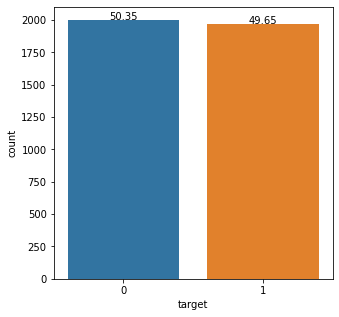

In [8]:
# Identifying label data from the whole datset and visualising label counts and display % of data as annotations

plt.figure(figsize=(5,5))

ax = sn.countplot(x="target", data=df)
for p in ax.patches:#displaying % as annotations
        ax.annotate(round(100*p.get_height()/len(df),2), (p.get_x()+0.3, p.get_height()+2))

print(df.target.value_counts())
print("Total Number:",sum(df.target.value_counts()))

#### We have a dataset with plenty of both labels to analyze and make a decent model.

In [9]:
# # create test data using unlabelled tweets

test_data = pd.read_csv('/content/drive/MyDrive/NetKu/merged_updated_test.csv')
val_data = pd.read_csv('/content/drive/MyDrive/NetKu/merged_updated_val.csv')

# indexNames = test_data[test_data['text'].isnull()].index
# print(indexNames)

# # Keep important columns
test_data = test_data[['paragraph', 'target']]
val_data = test_data[['paragraph', 'target']]

# # Display 5 samples from the test data
# test_data.sample(5)

In [10]:
data_train = df
data_val = val_data
X_train = data_train.paragraph.values
y_train = data_train.target.values
X_val = data_val.paragraph.values
y_val = data_val.target.values

#### we note no missing values in test tweets as well

In [11]:
import nltk
#download "stopwords"
nltk.download("stopwords")
from nltk.corpus import stopwords

def text_preprocessing(s):
    """
    - Lowercase the sentence
    - Change "'t" to "not"
    - Remove "@name"
    - Isolate and remove punctuations except "?"
    - Remove other special characters
    - Remove stop words except "not" and "can"
    - Remove trailing whitespace
    """
    s = s.lower()
    # Change 't to 'not'
    s = re.sub(r"\'t", " not", s)
    # Remove @name
    s = re.sub(r'(@.*?)[\s]', ' ', s)
    # Isolate and remove punctuations except '?'
    s = re.sub(r'([\'\"\.\(\)\!\?\\\/\,])', r' \1 ', s)
    s = re.sub(r'[^\w\s\?]', ' ', s)
    # Remove some special characters
    s = re.sub(r'([\;\:\|•«\n])', ' ', s)
    # Remove stopwords except 'not' and 'can'
    s = " ".join([word for word in s.split()
                  if word not in stopwords.words('english')
                  or word in ['not', 'can']])
    # Remove trailing whitespace
    s = re.sub(r'\s+', ' ', s).strip()
    
    return s

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
%%time
from sklearn.feature_extraction.text import TfidfVectorizer

# Preprocess text
X_train_preprocessed = np.array([text_preprocessing(text) for text in X_train])
X_val_preprocessed = np.array([text_preprocessing(text) for text in X_val])

# Calculate TF-IDF
tf_idf = TfidfVectorizer(ngram_range=(1, 3),
                         binary=True,
                         smooth_idf=False)
X_train_tfidf = tf_idf.fit_transform(X_train_preprocessed)
X_val_tfidf = tf_idf.transform(X_val_preprocessed)

In [ ]:
#use the appropriate device for model training
import torch

if torch.cuda.is_available():       
    device = torch.device("cuda")
    print(f'There are {torch.cuda.device_count()} GPU(s) available.')
    print('Device name:', torch.cuda.get_device_name(0))

else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

In [ ]:
def text_preprocessing(text):
    """
    - Remove entity mentions (eg. '@united')
    - Correct errors (eg. '&amp;' to '&')
    @param    text (str): a string to be processed.
    @return   text (Str): the processed string.
    """
    # Remove '@name'
    text = re.sub(r'(@.*?)[\s]', ' ', text)

    # Replace '&amp;' with '&'
    text = re.sub(r'&amp;', '&', text)

    # Remove trailing whitespace
    text = re.sub(r'\s+', ' ', text).strip()

    return text

In [ ]:
!pip install transformers

In [ ]:
from transformers import BartTokenizer

# Load the BERT tokenizer
tokenizer = BartTokenizer.from_pretrained('facebook/bart-large-mnli', do_lower_case=True)
# Create a function to tokenize a set of texts
def preprocessing_for_bart(data):
    """Perform required preprocessing steps for pretrained BERT.
    @param    data (np.array): Array of texts to be processed.
    @return   input_ids (torch.Tensor): Tensor of token ids to be fed to a model.
    @return   attention_masks (torch.Tensor): Tensor of indices specifying which
                  tokens should be attended to by the model.
    """
    # Create empty lists to store outputs
    input_ids = []
    attention_masks = []

    # For every sentence...
    for sent in data:
        # `encode_plus` will:
        #    (1) Tokenize the sentence
        #    (2) Add the `[CLS]` and `[SEP]` token to the start and end
        #    (3) Truncate/Pad sentence to max length
        #    (4) Map tokens to their IDs
        #    (5) Create attention mask
        #    (6) Return a dictionary of outputs
        encoded_sent = tokenizer.encode_plus(
            text=text_preprocessing(sent),  # Preprocess sentence
            add_special_tokens=True,        # Add `[CLS]` and `[SEP]`
            max_length=MAX_LEN,                  # Max length to truncate/pad
            pad_to_max_length=True,         # Pad sentence to max length
#             return_tensors='pt',           # Return PyTorch tensor
            return_attention_mask=True,
            truncation=True      # Return attention mask
            )
        
        # Add the outputs to the lists
        input_ids.append(encoded_sent.get('input_ids'))
        attention_masks.append(encoded_sent.get('attention_mask'))

    # Convert lists to tensors
    input_ids = torch.LongTensor(input_ids)
    attention_masks = torch.LongTensor(attention_masks)

    return input_ids, attention_masks

In [ ]:
# Concatenate train data and test data
all_tweets = np.concatenate([df.paragraph.values, test_data.paragraph.values])

# Encode our concatenated data
encoded_tweets = [tokenizer.encode(sent, add_special_tokens=True) for sent in all_tweets]

# Find the maximum length
max_len = max([len(sent) for sent in encoded_tweets])
print('Max length: ', max_len)
# Specify `MAX_LEN`
MAX_LEN = 90

In [ ]:
# Print sentence 0 and its encoded token ids
# token_ids = list(preprocessing_for_bart([X[0]])[0].squeeze().numpy())
# print('Original: ', X[0])
# print('Token IDs: ', token_ids)

# Run function `preprocessing_for_bert` on the train set and the validation set
print('Tokenizing data...')
train_inputs, train_masks = preprocessing_for_bart(X_train)
val_inputs, val_masks = preprocessing_for_bart(X_val)

In [ ]:
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

# Convert other data types to torch.Tensor
train_labels = torch.LongTensor(y_train)
val_labels = torch.LongTensor(y_val)

# For fine-tuning BERT, the authors recommend a batch size of 16 or 32.
batch_size = 16

# Create the DataLoader for our training set
train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

# Create the DataLoader for our validation set
val_data = TensorDataset(val_inputs, val_masks, val_labels)
val_sampler = SequentialSampler(val_data)
val_dataloader = DataLoader(val_data, sampler=val_sampler, batch_size=batch_size)

In [ ]:
%%time
import torch
import torch.nn as nn
from transformers import BartModel

# Create the BartClassfier class 
class BartClassifier(nn.Module):
    """Bert Model for Classification Tasks.
    """
    def __init__(self, freeze_bart=False):
        """
        @param    bert: a BertModel object
        @param    classifier: a torch.nn.Module classifier
        @param    freeze_bart (bool): Set `False` to fine-tune the BART model
        """
        super(BartClassifier, self).__init__()
        # Specify hidden size of BART, hidden size of our classifier, and number of labels
        D_in, H, D_out = 1024, 50, 2

        # Instantiate BART model
        self.bart = BartModel.from_pretrained('facebook/bart-large-mnli')

        # Instantiate an one-layer feed-forward classifier
        self.classifier = nn.Sequential(
            nn.Linear(D_in, H),
            nn.ReLU(),
            #nn.Dropout(0.5),
            nn.Linear(H, D_out)
        )

        # Freeze the BART model
        if freeze_bart:
            for param in self.bart.parameters():
                param.requires_grad = False
        
    def forward(self, input_ids, attention_mask):
        """
        Feed input to BART and the classifier to compute logits.
        @param    input_ids (torch.Tensor): an input tensor with shape (batch_size,
                      max_length)
        @param    attention_mask (torch.Tensor): a tensor that hold attention mask
                      information with shape (batch_size, max_length)
        @return   logits (torch.Tensor): an output tensor with shape (batch_size,
                      num_labels)
        """
        # Feed input to BART
        outputs = self.bart(input_ids=input_ids,
                            attention_mask=attention_mask)
        
        # Extract the last hidden state of the token `[CLS]` for classification task
        last_hidden_state_cls = outputs[0][:, 0, :]

        # Feed input to classifier to compute logits
        logits = self.classifier(last_hidden_state_cls)

        return logits

In [ ]:
from transformers import AdamW, get_linear_schedule_with_warmup

def initialize_model(epochs=3):
    """Initialize the Bart Classifier, the optimizer and the learning rate scheduler.
    """
    # Instantiate Bert Classifier
    bart_classifier = BartClassifier(freeze_bart=False)

    # Tell PyTorch to run the model on GPU
    bart_classifier.to(device)

    # Create the optimizer
    optimizer = AdamW(bart_classifier.parameters(),
                      lr=5e-5,    # Default learning rate
                      eps=1e-8    # Default epsilon value
                      )

    # Total number of training steps
    total_steps = len(train_dataloader) * epochs

    # Set up the learning rate scheduler
    scheduler = get_linear_schedule_with_warmup(optimizer,
                                                num_warmup_steps=0, # Default value
                                                num_training_steps=total_steps)
    return bart_classifier, optimizer, scheduler

In [ ]:
import random
import time

# Specify loss function
loss_fn = nn.CrossEntropyLoss()

def set_seed(seed_value=42):
    """Set seed for reproducibility.
    """
    random.seed(seed_value)
    np.random.seed(seed_value)
    torch.manual_seed(seed_value)
    torch.cuda.manual_seed_all(seed_value)

def train(model, train_dataloader, val_dataloader=None, epochs=3, evaluation=False):
    """Train the BartClassifier model.
    """
    # Start training loop
    print("Start training...\n")
    for epoch_i in range(epochs):
        # =======================================
        #               Training
        # =======================================
        # Print the header of the result table
        print(f"{'Epoch':^7} | {'Batch':^7} | {'Train Loss':^12} | {'Val Loss':^10} | {'Val Acc':^9} | {'Elapsed':^9}")
        print("-"*70)

        # Measure the elapsed time of each epoch
        t0_epoch, t0_batch = time.time(), time.time()

        # Reset tracking variables at the beginning of each epoch
        total_loss, batch_loss, batch_counts = 0, 0, 0

        # Put the model into the training mode
        model.train()

        # For each batch of training data...
        for step, batch in enumerate(train_dataloader):
            batch_counts +=1
            # Load batch to GPU
            b_input_ids, b_attn_mask, b_labels = tuple(t.to(device) for t in batch)

            # Zero out any previously calculated gradients
            model.zero_grad()

            # Perform a forward pass. This will return logits.
            logits = model(b_input_ids, b_attn_mask)

            # Compute loss and accumulate the loss values
            loss = loss_fn(logits, b_labels)
            batch_loss += loss.item()
            total_loss += loss.item()

            # Perform a backward pass to calculate gradients
            loss.backward()

            # Clip the norm of the gradients to 1.0 to prevent "exploding gradients"
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

            # Update parameters and the learning rate
            optimizer.step()
            scheduler.step()

            # Print the loss values and time elapsed for every 20 batches
            if (step % 20 == 0 and step != 0) or (step == len(train_dataloader) - 1):
                # Calculate time elapsed for 20 batches
                time_elapsed = time.time() - t0_batch

                # Print training results
                print(f"{epoch_i + 1:^7} | {step:^7} | {batch_loss / batch_counts:^12.6f} | {'-':^10} | {'-':^9} | {time_elapsed:^9.2f}")

                # Reset batch tracking variables
                batch_loss, batch_counts = 0, 0
                t0_batch = time.time()

        # Calculate the average loss over the entire training data
        avg_train_loss = total_loss / len(train_dataloader)

        print("-"*70)
        # =======================================
        #               Evaluation
        # =======================================
        if evaluation == True:
            # After the completion of each training epoch, measure the model's performance
            # on our validation set.
            val_loss, val_accuracy = evaluate(model, val_dataloader)

            # Print performance over the entire training data
            time_elapsed = time.time() - t0_epoch
            
            print(f"{epoch_i + 1:^7} | {'-':^7} | {avg_train_loss:^12.6f} | {val_loss:^10.6f} | {val_accuracy:^9.2f} | {time_elapsed:^9.2f}")
            print("-"*70)
        print("\n")
    output_model = '/content/drive/MyDrive/NetKu/encoder_bart.pth'
    torch.save({
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict()
    }, output_model)
    model.save_pretrained("/content/drive/MyDrive/NetKu/encoder_bart", from_pt=True) 
    
    print("Training complete!")


def evaluate(model, val_dataloader):
    """After the completion of each training epoch, measure the model's performance
    on our validation set.
    """
    # Put the model into the evaluation mode. The dropout layers are disabled during
    # the test time.
    model.eval()

    # Tracking variables
    val_accuracy = []
    val_loss = []

    # For each batch in our validation set...
    for batch in val_dataloader:
        # Load batch to GPU
        b_input_ids, b_attn_mask, b_labels = tuple(t.to(device) for t in batch)

        # Compute logits
        with torch.no_grad():
            logits = model(b_input_ids, b_attn_mask)

        # Compute loss
        loss = loss_fn(logits, b_labels)
        val_loss.append(loss.item())

        # Get the predictions
        preds = torch.argmax(logits, dim=1).flatten()

        # Calculate the accuracy rate
        accuracy = (preds == b_labels).cpu().numpy().mean() * 100
        val_accuracy.append(accuracy)

    # Compute the average accuracy and loss over the validation set.
    val_loss = np.mean(val_loss)
    val_accuracy = np.mean(val_accuracy)

    return val_loss, val_accuracy

In [ ]:
import gc

gc.collect()

In [ ]:
torch.cuda.empty_cache()

In [ ]:
set_seed(42)    # Set seed for reproducibility
bart_classifier, optimizer, scheduler = initialize_model(epochs=3)
train(bart_classifier, train_dataloader, val_dataloader, epochs=3, evaluation=True)

In [ ]:
import torch.nn.functional as F

def bart_predict(model, test_dataloader):
    """Perform a forward pass on the trained BERT model to predict probabilities
    on the test set.
    """
    # Put the model into the evaluation mode. The dropout layers are disabled during
    # the test time.
    model.eval()

    all_logits = []

    # For each batch in our test set...
    for batch in test_dataloader:
        # Load batch to GPU
        b_input_ids, b_attn_mask = tuple(t.to(device) for t in batch)[:2]

        # Compute logits
        with torch.no_grad():
            logits = model(b_input_ids, b_attn_mask)
        all_logits.append(logits)
    
    # Concatenate logits from each batch
    all_logits = torch.cat(all_logits, dim=0)

    # Apply softmax to calculate probabilities
    probs = F.softmax(all_logits, dim=1).cpu().numpy()

    return probs

In [ ]:
from sklearn.metrics import accuracy_score, roc_curve, auc

def evaluate_roc(probs, y_true):
    """
    - Print AUC and accuracy on the test set
    - Plot ROC
    @params    probs (np.array): an array of predicted probabilities with shape (len(y_true), 2)
    @params    y_true (np.array): an array of the true values with shape (len(y_true),)
    """
    preds = probs[:, 1]
    fpr, tpr, threshold = roc_curve(y_true, preds)
    roc_auc = auc(fpr, tpr)
    print(f'AUC: {roc_auc:.4f}')
       
    # Get accuracy over the test set
    y_pred = np.where(preds >= 0.82, 1, 0)
    accuracy = accuracy_score(y_true, y_pred)
    print(f'Accuracy: {accuracy*100:.2f}%')
    
    # Plot ROC AUC
    plt.title('Receiver Operating Characteristic')
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

In [ ]:
# Compute predicted probabilities on the test set
probs = bart_predict(bart_classifier, val_dataloader)

# Evaluate the Bart classifier
evaluate_roc(probs, y_val)

In [ ]:
# Compute predicted probabilities on the test set
probs = bart_predict(bart_classifier, val_dataloader)

# Evaluate the Bert classifier
evaluate_roc(probs, y_val)

In [ ]:
# Concatenate the train set and the validation set
full_train_data = torch.utils.data.ConcatDataset([train_data, val_data])
full_train_sampler = RandomSampler(full_train_data)
full_train_dataloader = DataLoader(full_train_data, sampler=full_train_sampler, batch_size=16)

# Train the Bart Classifier on the entire training data
set_seed(42)
bart_classifier, optimizer, scheduler = initialize_model(epochs=3)
train(bart_classifier, full_train_dataloader, epochs=3)

In [ ]:
test_df = test_data
# Run `preprocessing_for_bart` on the test set
print('Tokenizing data...')
test_inputs, test_masks = preprocessing_for_bart(test_df.paragraph)

# Create the DataLoader for our test set
test_dataset = TensorDataset(test_inputs, test_masks)
test_sampler = SequentialSampler(test_dataset)
test_dataloader = DataLoader(test_dataset, sampler=test_sampler, batch_size=32)

In [ ]:
# Compute predicted probabilities on final test data
probs = bart_predict(bart_classifier, test_dataloader)

In [ ]:
probs

In [ ]:
preds = probs[:, 1]
preds

In [ ]:
# id = test_data.id
submission = pd.DataFrame()
submission['target_p'] = preds
submission['target'] = submission.target_p.map( 
                            lambda x: 1 if x > 0.6 else 0)
submission = submission[['target']]
submission

In [ ]:
submission.to_csv("/content/drive/MyDrive/NetKu/submission_sec.csv",index=False)

In [ ]:
submission.target.value_counts()